# Baysian Elections Prediction
In this notebook you can find the code for my humble forecasting model for the Israeli 2022 elections. 

It uses a Baysian framework where the prior is derived from the previous elections held in 2021, and the data are the most recent polls.

The final estimations for the seats distribution per party is then produced taking into account both the model's prediction as well as the Israeli election laws:
1. Each party has to get a least 3.25% of the votes
2. The residuals are allocated based on the Bader-Ofer method and the residual agreements 
Data:
https://www.gov.il/he/Departments/Guides/knesset25-elections-info?chapterIndex=13


In [ ]:
!pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 8.2 MB/s 
     |████████████████████████████████| 1.8 MB 37.8 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=a8d3734b704e9181b61b45aa72f1d2a53d4fa5bb5308fa872848c50b5c375ca2
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built theano-pymc


In [ ]:
from typing import Tuple, List

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import scipy.stats
import seaborn as sns
import plotly.graph_objects as go
from plotly.colors import n_colors
import plotly.express as px

# Example - Binomial distribution
First, a simplified example of Baysian inference. Let's assume we have a coin with an unknown probablity p of getting "head".

We tossed the coin 10 times and got "heads" 6 times. 

As we know nothing about the problem, we assume that the prior distribution for the parameter p is uniform between 0 and 1. 



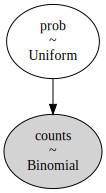

In [ ]:
observed_data = np.array([6])

with pm.Model() as model_binomial:
    prob = pm.Uniform("prob", lower=0, upper=1)
    # prob = pm.Beta("prob", 10, 10)
    counts = pm.Binomial("counts", 
                          n=10, 
                          p=prob, 
                          observed=observed_data)
    prior_checks = pm.sample_prior_predictive(samples=5000, 
                                              random_seed=42)
        
    trace = pm.sample(
        draws=int(5e3), 
        chains=1, 
        step=pm.Metropolis(), 
        return_inferencedata=True
    )


pm.model_to_graphviz(model_binomial)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


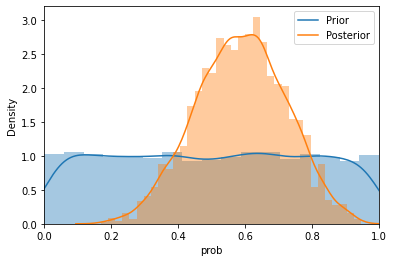

In [ ]:
sns.distplot(prior_checks['prob'])
sns.distplot(trace.posterior.data_vars['prob'])
plt.xlim([0, 1])
plt.legend(['Prior', 'Posterior'])

Now let's assume that we do have some knowledge about the world. We know most coins are "fair", that is the probablitieis for heads and tail are equal. 

So we can have a Beta(10,10) distribution for the parameter be which is centered at 0.5 but has some width.

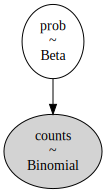

In [ ]:
with pm.Model() as model_binomial:
    #prob = pm.Uniform("prob", lower=0, upper=1)
    prob = pm.Beta("prob", 10, 10)
    counts = pm.Binomial("counts", 
                          n=10, 
                          p=prob, 
                          observed=observed_data)
    prior_checks = pm.sample_prior_predictive(samples=5000, 
                                              random_seed=42)
        
    trace = pm.sample(
        draws=int(5e3), 
        chains=1, 
        step=pm.Metropolis(), 
        return_inferencedata=True
    )


pm.model_to_graphviz(model_binomial)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


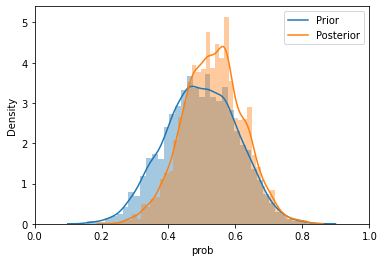

In [ ]:
sns.distplot(prior_checks['prob'])
sns.distplot(trace.posterior.data_vars['prob'])
plt.xlim([0, 1])
plt.legend(['Prior', 'Posterior'])

# Elections Forecast
Now let's move to the election data. We assume the results are multinomibal as opposed to the binomial distribution when using the coin toss example, and the probabilities p for each party come from a Dirichlet distribution which is a high dimensional generalization og the Beta distribution. 

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

The prior for the parameter p (the fraction of each party) is derived from the previous elections:

In [ ]:
prev_election = {'likud': 0.2419,
         'yesh_atid': 0.1393,
         'shas': 0.0717,
         'kahol_laven': 0.0663,
         'yamina': 0.0621,
         'labor': 0.0609,
         'yehadut_hatorah': 0.0563,
         'israel_beytenu': 0.0563,
         'zionut_datit': 0.0512,
         'joint_list': 0.0482,
         'new_hope': 0.0474,
         'meretz': 0.0459,
         'raam': 0.0379}

prev_election['other'] = 1 - sum(prev_election.values())

Since there are several new parties, or parties that dissolved into multiple parties, I had to manually adjust some of the values based solely on my intuition

In [ ]:
parties = ['likud', 'yesh_atid', 'mahane_mamlahti', 'shas', 'bait_yeudi', 
           'labor', 'yehadut_hatorah', 'israel_beytenu', 'zionut_datit',
           'joint_list', 'meretz', 'raam', 'balad', 'abir_kara', 
           'hadar_muchtar', 'yaron_zelicha']

prior = {}

# Objective Priors
for party, value in prev_election.items():
  if party in parties:
    prior[party] = value

# Custom Priors
prior['likud'] = prev_election['likud'] + prev_election['yamina']*0.66
prior['mahane_mamlahti'] = prev_election['kahol_laven'] + prev_election['new_hope'] + prev_election['yamina']*0.09
prior['bait_yeudi'] = prev_election['yamina']*0.15
prior['zionut_datit'] =  prev_election['zionut_datit'] + prev_election['yamina']*0.1
prior['joint_list'] = prev_election['joint_list']*0.84
prior['balad'] = prev_election['joint_list']*0.16

# Allocate "other" to new parties with no custom priors
new_parties = [party for party in parties if party not in prior]
num_new_parties = len(new_parties)

for party in new_parties:
  prior[party] = prev_election['other']/num_new_parties

In [ ]:
sum(prior.values())

In [ ]:
agreements = [('likud', 'zionut_datit'),
              ('yesh_atid', 'mahane_mamlahti'),
              ('labor', 'meretz'), 
              ('shas', 'yehadut_hatorah'),
              ('raam', 'joint_list')]

bibi = ['likud', 'zionut_datit', 'shas', 'yehadut_hatorah', 'bait_yeudi']
not_bibi = [x for x in prior if x not in bibi]

In [ ]:
plt.barh(list(prior.keys()),
         list(prior.values()))


# Categorical Distribution

In [ ]:
polls = pd.read_csv('/content/All_polls_absolute - גיליון1.csv')
polls.head()

In [ ]:
polls['yehadut_hatorah'] = polls['יהדות התורה']
polls = polls[list(prior.keys())]
def parse_polls(df):
  ans = []
  for ind, col in enumerate(df[list(prior.keys())]):
    ans.append(np.ones(df[col].sum())*ind)
  ans = np.array([np.array(item) for sublist in ans for item in sublist])
  return ans

ans = parse_polls(polls)  

In [ ]:
np.zeros(len(prior))

ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


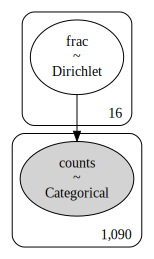

In [ ]:
prior_width_param = 1000

with pm.Model() as model_categorical:
    frac = pm.Dirichlet("frac", 
                        a=prior_width_param*np.array(list(prior.values())))
                        #a=np.ones(len(prior)))
    counts = pm.Categorical("counts", 
                            p=frac, 
                         #   shape=(len(polls), polls.shape[1]), 
                            observed=ans)
    prior_checks = pm.sample_prior_predictive(samples=50, 
                                              random_seed=RANDOM_SEED)
        
    trace_categorical = pm.sample(
        draws=int(1e3), 
        chains=4, 
        step=pm.Metropolis(), 
        return_inferencedata=True
    )


pm.model_to_graphviz(model_categorical)

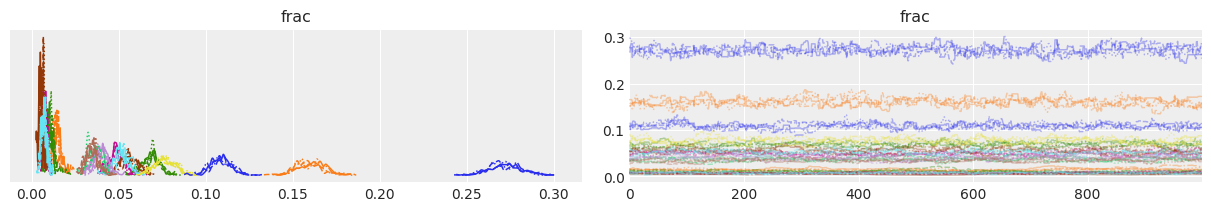

In [ ]:
az.plot_trace(data=trace_categorical, var_names=["frac"]);


In [ ]:
summary_categorical = az.summary(trace_categorical, var_names=["frac"])

summary_categorical

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
frac[0]   0.272  0.009   0.255    0.289      0.001    0.000     243.0   
frac[1]   0.160  0.008   0.145    0.175      0.001    0.001     101.0   
frac[2]   0.069  0.005   0.058    0.077      0.000    0.000     112.0   
frac[3]   0.049  0.004   0.040    0.056      0.000    0.000      77.0   
frac[4]   0.056  0.005   0.047    0.066      0.001    0.001      36.0   
frac[5]   0.052  0.004   0.043    0.060      0.001    0.001      28.0   
frac[6]   0.077  0.006   0.065    0.087      0.001    0.001      61.0   
frac[7]   0.037  0.004   0.029    0.045      0.001    0.001      27.0   
frac[8]   0.040  0.004   0.031    0.047      0.001    0.000      47.0   
frac[9]   0.035  0.004   0.029    0.042      0.000    0.000      69.0   
frac[10]  0.109  0.006   0.098    0.120      0.001    0.000     138.0   
frac[11]  0.014  0.003   0.010    0.019      0.001    0.000      21.0   
frac[12]  0.011  0.002   0.007    0.014      0.000    0.000      38.0   
frac[13]  0.007  0.002   0.004    0.010      0.000    0.000      10.0   
frac[14]  0.006  0.001   0.004    0.009      0.000    0.000      10.0   
frac[15]  0.007  0.002   0.005    0.011      0.000    0.000     121.0   

          ess_tail  r_hat  
frac[0]      395.0   1.01  
frac[1]      342.0   1.04  
frac[2]      206.0   1.05  
frac[3]      136.0   1.04  
frac[4]      185.0   1.08  
frac[5]       97.0   1.11  
frac[6]      217.0   1.06  
frac[7]      128.0   1.14  
frac[8]      106.0   1.07  
frac[9]      109.0   1.04  
frac[10]     176.0   1.02  
frac[11]      38.0   1.14  
frac[12]      45.0   1.06  
frac[13]      43.0   1.33  
frac[14]      30.0   1.41  
frac[15]     368.0   1.03

In [ ]:
summary_categorical = az.summary(trace_categorical, var_names=["frac"])

summary_categorical

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
frac[0]   0.272  0.009   0.255    0.289      0.001    0.000     243.0   
frac[1]   0.160  0.008   0.145    0.175      0.001    0.001     101.0   
frac[2]   0.069  0.005   0.058    0.077      0.000    0.000     112.0   
frac[3]   0.049  0.004   0.040    0.056      0.000    0.000      77.0   
frac[4]   0.056  0.005   0.047    0.066      0.001    0.001      36.0   
frac[5]   0.052  0.004   0.043    0.060      0.001    0.001      28.0   
frac[6]   0.077  0.006   0.065    0.087      0.001    0.001      61.0   
frac[7]   0.037  0.004   0.029    0.045      0.001    0.001      27.0   
frac[8]   0.040  0.004   0.031    0.047      0.001    0.000      47.0   
frac[9]   0.035  0.004   0.029    0.042      0.000    0.000      69.0   
frac[10]  0.109  0.006   0.098    0.120      0.001    0.000     138.0   
frac[11]  0.014  0.003   0.010    0.019      0.001    0.000      21.0   
frac[12]  0.011  0.002   0.007    0.014      0.000    0.000      38.0   
frac[13]  0.007  0.002   0.004    0.010      0.000    0.000      10.0   
frac[14]  0.006  0.001   0.004    0.009      0.000    0.000      10.0   
frac[15]  0.007  0.002   0.005    0.011      0.000    0.000     121.0   

          ess_tail  r_hat  
frac[0]      395.0   1.01  
frac[1]      342.0   1.04  
frac[2]      206.0   1.05  
frac[3]      136.0   1.04  
frac[4]      185.0   1.08  
frac[5]       97.0   1.11  
frac[6]      217.0   1.06  
frac[7]      128.0   1.14  
frac[8]      106.0   1.07  
frac[9]      109.0   1.04  
frac[10]     176.0   1.02  
frac[11]      38.0   1.14  
frac[12]      45.0   1.06  
frac[13]      43.0   1.33  
frac[14]      30.0   1.41  
frac[15]     368.0   1.03

In [ ]:
prior.keys()

dict_keys(['likud', 'yesh_atid', 'shas', 'labor', 'yehadut_hatorah', 'israel_beytenu', 'zionut_datit', 'joint_list', 'meretz', 'raam', 'mahane_mamlahti', 'bait_yeudi', 'balad', 'abir_kara', 'hadar_muchtar', 'yaron_zelicha'])

# Multinomial Model

In [ ]:
polls = pd.read_csv('/content/polls_seats - גיליון1.csv')

polls['yesh_atid'] = polls['yeah_atid']
polls = polls[list(prior.keys())]

ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


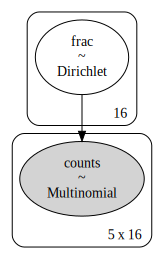

In [ ]:
prior_width_param = 1000

with pm.Model() as model_multinomial:
    frac = pm.Dirichlet("frac", 
                        a=prior_width_param*np.array(list(prior.values())))
    counts = pm.Multinomial("counts", 
                            n=120, 
                            p=frac, 
                            shape=(len(polls), polls.shape[1]), 
                            observed=polls.values)
    prior_checks = pm.sample_prior_predictive(samples=5000, 
                                              random_seed=RANDOM_SEED)
        
    trace_multinomial = pm.sample(
        draws=int(5e3), 
        chains=4, 
        step=pm.Metropolis(), 
        return_inferencedata=True
    )


pm.model_to_graphviz(model_multinomial)

# Plot Prior Distribution

In [ ]:
colors = n_colors('rgb(5, 200, 200)', 'rgb(200, 10, 10)', len(prior), colortype='rgb')
parties = prior_checks['counts'][:, 0, :].shape[1]
fig = go.Figure()
for data_line, color in zip(range(parties), colors):
    fig.add_trace(go.Violin(x=prior_checks['counts'][:, 0, :][:, data_line], 
                            line_color=color,
                            name=list(prior.keys())[data_line]))

fig.update_traces(orientation='h', side='positive', width=3, points=False)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False)
fig.show()

In [ ]:
with model_multinomial:
    ppc = pm.sample_posterior_predictive(
        trace_multinomial, 
        var_names=["frac", "counts"], 
        random_seed=RANDOM_SEED
    )

In [ ]:
colors = n_colors('rgb(5, 200, 200)', 'rgb(200, 10, 10)', len(prior), colortype='rgb')
parties = ppc['counts'][:, 0, :].shape[1]
fig = go.Figure()
for data_line, color in zip(range(parties), colors):
    fig.add_trace(go.Violin(x=ppc['counts'][:, 0, :][:, data_line], 
                            y=[list(prior.keys())[data_line]]*5000,
                            line_color='blue',
                            name=list(prior.keys())[data_line]))
    fig.add_trace(go.Violin(x=prior_checks['counts'][:, 0, :][:, data_line], 
                            y=[list(prior.keys())[data_line]]*5000,
                            line_color='red',
                            name=list(prior.keys())[data_line] + '_prior'))

fig.update_traces(orientation='h', side='positive', width=3, points=False)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False)
fig.show()

# Plot Posterior Distribution for each party fraction

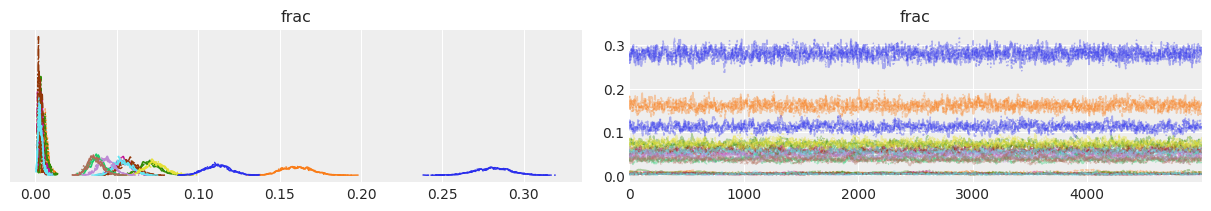

In [ ]:
az.plot_trace(data=trace_multinomial, var_names=["frac"]);


# Summary statistics for each estimated parameter

In [ ]:
summary_multinomial = az.summary(trace_multinomial, var_names=["frac"])

summary_multinomial

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
frac[0]   0.281  0.011   0.260    0.301        0.0      0.0    1280.0   
frac[1]   0.161  0.009   0.144    0.178        0.0      0.0     960.0   
frac[2]   0.071  0.006   0.058    0.083        0.0      0.0     497.0   
frac[3]   0.054  0.006   0.043    0.064        0.0      0.0     465.0   
frac[4]   0.057  0.006   0.046    0.068        0.0      0.0     426.0   
frac[5]   0.053  0.006   0.042    0.064        0.0      0.0     436.0   
frac[6]   0.074  0.006   0.063    0.087        0.0      0.0     621.0   
frac[7]   0.038  0.005   0.028    0.046        0.0      0.0     301.0   
frac[8]   0.043  0.005   0.034    0.053        0.0      0.0     389.0   
frac[9]   0.037  0.005   0.028    0.046        0.0      0.0     351.0   
frac[10]  0.112  0.008   0.097    0.126        0.0      0.0     812.0   
frac[11]  0.006  0.002   0.002    0.009        0.0      0.0      57.0   
frac[12]  0.005  0.002   0.002    0.009        0.0      0.0      15.0   
frac[13]  0.004  0.002   0.001    0.007        0.0      0.0      46.0   
frac[14]  0.003  0.001   0.001    0.005        0.0      0.0      16.0   
frac[15]  0.003  0.001   0.001    0.005        0.0      0.0     385.0   

          ess_tail  r_hat  
frac[0]     1851.0   1.00  
frac[1]     1452.0   1.00  
frac[2]      884.0   1.01  
frac[3]      641.0   1.01  
frac[4]      732.0   1.01  
frac[5]      765.0   1.01  
frac[6]      947.0   1.01  
frac[7]      638.0   1.01  
frac[8]      707.0   1.00  
frac[9]      735.0   1.01  
frac[10]    1193.0   1.00  
frac[11]      66.0   1.07  
frac[12]      89.0   1.21  
frac[13]      43.0   1.08  
frac[14]     142.0   1.19  
frac[15]     659.0   1.01

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3f2ddf9bd0>],
      dtype=object)

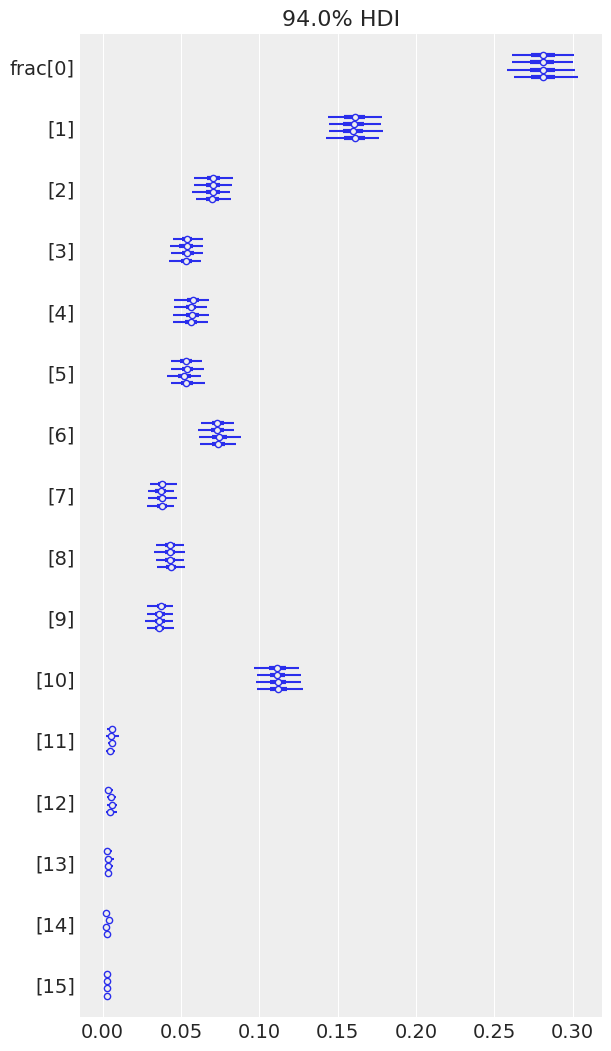

In [ ]:
az.plot_forest(trace_multinomial, var_names=["frac"])

# Allocate seats based on the Israeli elections system

In [ ]:
THRESHOLD = 0.0325
SEATS = 120
VOTES_FOR_SEAT = 32000

def allocate_seats(results_vector: np.array, agreements: List[Tuple]) -> List:
  # Get rid of parties below threshold
  results_vector = [0 if x < THRESHOLD else x for x in results_vector]

  # Translate % to seats
  results_vector = [SEATS*x/sum(results_vector) for x in results_vector]

  # Seats to be allocated based on agreements abd Bader-Offer
  missing_seats = SEATS - (sum([int(x) for x in results_vector]))

  # Allocate based on residual agreements and Bader-Offer
  for seat in range(missing_seats):
    results_vector = badder_ofer(results_vector, agreements)
  
  # Round the results to lower integer
  results_vector = [int(x) for x in results_vector]

  return results_vector
  
def badder_ofer(results_vector: List, agreements: List[Tuple]) -> List:
  # Add fake agreement for parties with no residual agreement
  no_agreements = [x for x in range(len(results_vector)) 
                   if x not in np.unique(agreements)]
  for i in no_agreements:
    agreements.append((i, len(results_vector)))
  # Add a fake party with zero votes for parties with no residual agreement
  results_vector.append(0)

  # Add together the votes for parties with a residual agreement
  agreemnts_vector = [VOTES_FOR_SEAT*results_vector[x[0]] +
                      VOTES_FOR_SEAT*results_vector[x[1]] 
                      for x in agreements] 
  
  # Based on the Bader-Ofer method, parties with a residual agreement would be
  # Considered as one party for the allocation method
  agreements_vector_denom = [int(results_vector[x[0]]) + 
                             int(results_vector[x[1]]) + 1 
                             for x in agreements]   
  
  # Calculate the "price per seat" based on the Bader-Ofer method 
  prices_vector = [VOTES_FOR_SEAT*x/y for x, y in 
                   zip(agreemnts_vector, agreements_vector_denom)]

  # Find the parties pair (based on agreements) who wins the extra seat
  winning_pair = agreements[np.argmax(prices_vector)]
  winning_pair_values = [results_vector[winning_pair[0]], 
                         results_vector[winning_pair[1]]]
  
  # Allocate the extra seat for the party that has the higer "price per seat"
  # Among the two parties from the winning pair 
  prices_within_agreement = [VOTES_FOR_SEAT*x/(int(x) + 1) 
                             for x in winning_pair_values]
  winning_party = np.argmax(prices_within_agreement)
  winning_ind = winning_pair[winning_party]

  # Add an extra seat to the party that won the Bader-Ofer process
  results_vector[winning_ind] = int(results_vector[winning_ind]) + 1

  # Return the results, omitting the fake party with zero votes
  return results_vector[:-1]

In [ ]:
def parse_agreements(prior, agreements):
  parsed_agreements = []
  for agreement in agreements:
    parsed_agreements.append((list(prior.keys()).index(agreement[0]),
                              list(prior.keys()).index(agreement[1])))
  return parsed_agreements



In [ ]:
vals = trace_multinomial.posterior.data_vars['frac'][0]
vals = [x.values for x in vals]

mandates = np.zeros(shape=(len(vals), 
                           vals[0].shape[0]))

parsed_agreements = parse_agreements(prior, agreements)

for i in range(len(vals)):
  mandates[i, :] = allocate_seats(vals[i], parsed_agreements)

df = pd.DataFrame(mandates)
df.columns = prior.keys()

NameError: ignored

In [ ]:
df.head()

Define "Bibi" and "not-Bibi" blocks

In [ ]:
df[bibi].sum(axis=1).hist(bins=np.arange(50, 80, 1), width=0.8)
plt.plot([61, 61], [0, 600], '--')
ans = df[bibi].sum(axis=1)
plt.title(f'Bibi has a {len(ans[ans > 60])/len(ans)} chance of reaching 61')

Chances for getting a 60-60 tie:

In [ ]:
len(ans[ans == 60])/len(ans)

In [ ]:
fig = px.histogram(pd.DataFrame(df[bibi].sum(axis=1)), x=0,
                   labels={'x':'total_bill', 'y':'count'})
fig.update_layout(bargap=0.2)
fig.update_layout(title = f'{str(len(ans[ans > 60])/len(ans))[:4]} הסיכוי של גוש ביבי להגיע ל-61 הוא')


fig.show()

Chances of passing the threshold:

In [ ]:
for col in df.columns:
  print(f'Chances for {col} to pass the threshold: {len(df[df[col]>3])/len(df)}')


Chances bibi has 61 if all parties pass the threshold:

In [ ]:
ans = df[(df[11] > 3) & (df[10] > 3) & (df[9] > 3)][bibi].sum(axis=1)
len(ans[ans > 60])/len(ans)

Chances all parties (but Balad and Jewish Home) pass the threshold:

In [ ]:
len(df[(df[11] > 3) & (df[10] > 3) & (df[9] > 3)])/len(df)

0.7224

In [ ]:
df[bibi].sum(axis=1).value_counts()

60.0    1133
61.0     939
59.0     812
62.0     582
63.0     455
58.0     436
64.0     250
57.0     214
65.0     124
56.0      31
66.0      10
67.0       6
55.0       5
69.0       3
dtype: int64

In [ ]:
df.mean()

0     36.7750
1     20.3802
2     10.2760
3      7.7714
4      3.2958
5      6.2684
6      6.8838
7      5.2814
8      8.3410
9      3.6220
10    11.1050
11     0.0000
12     0.0000
13     0.0000
14     0.0000
15     0.0000
dtype: float64